# Interacción con Open Street Maps mediante API

[Open Street Map](https://www.openstreetmap.org/#map=4/-40.44/-63.59) es un proyecto colaborativo que condensa muchas herramientas para trabajar con datos georeferenciados, mapas, movilidad, etc. Podemos pensarlo como un mapa con información cargada por sus usuarios.

Dependiendo lo que estemos queriendo hacer, existen distintas APIs que interactúan con OSM. Algunas trabajan con datos de forma remota (la que veremos hoy), otras nos permiten descargar datos y trabajarlos localmente (osmnx, para trabajar con redes de calles).

Hoy, vamos a usar la [Open Source Routing Machine](http://project-osrm.org/), que utiliza la información de OSM y algoritmos de ruteo para darnos información sobre distancia y tiempo de viaje entre dos lugares.

## ¿Qué tanto se aleja Buenos Aires del sueño euclideo?

Una vez que aprendemos que la hipotenusa es más chica que sumar los catetos, queremos andar metiendo diagonales por todos lados. Nunca faltan los senderos autoinducidos en los parques que acortan las distancias propuestas por los paisajistas.

Veamos entonces, dados n puntos aleatorios de Buenos Aires, cuál es su distancia euclídea vs cuál es su distancia tomando las calles. De esta forma, tendremos una noción de qué tanto se aleja el entramado urbano del sueño euclídeo.

In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 

# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install pyproj

import pandas as pd
import requests # Con la que enviamos pedidos a la api
import geopandas as gpd # Para manejar objetos geometricos en un data frame
import random as rm # Cosas random
import matplotlib.pylab as plt # Visualizacion
import numpy as np # Matemáticas
import shapely.geometry as geometry #Geometrías en 2D
import pyproj # Geometrías en 3D

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-upda

### ¿Cómo se hace un requests y cómo se ve?

Rápidamente, veamos cómo se hace un requests en esta api

In [ ]:
# Definimos los parámetros
lon1, lat1 =  -58.44931065496426, -34.589964078164115 # Desde
lon2, lat2 =  -58.44395974951271, -34.54236193536392# Hasta
profile = 'car' # En auto

url = f'http://router.project-osrm.org/route/v1/{profile}/{lon1},{lat1};{lon2},{lat2}?overview=full&geometries=geojson'

s = requests.sessions.Session() # Generamos una sesión, veremos esto en detalle la clase que viene
r = s.get(url) # Con la sesión, generamos un requests de tipo get, apuntando al url que definimos arriba

print(f'El status del pedido es {r.status_code}')
print(f'La información que nos está devolviendo es {list(r.json().keys())}')
print(f'La distancia del trayecto es: {r.json()["routes"][0]["distance"]} mts')

El status del pedido es 200
La información que nos está devolviendo es ['code', 'routes', 'waypoints']
La distancia del trayecto es: 8790.8 mts


In [ ]:
# Primero, hacemos una función para encontrar n puntos aleatorios dentro de un polígono

def puntos_aleatorios(n, poligono):
    puntos = [] # Lista de puntos aleatorios
    i = 0 # contador
    x_min, y_min, x_max, y_max = poligono.bounds # límites del polígono
    while i < n:
        x, y = rm.uniform(x_min, x_max), rm.uniform(y_min, y_max) # buscamos un punto aleatorio
        p = geometry.Point(x, y)
        if p.intersects(poligono): # chequeamos que esté en el polígono (pensar que el bounds nos genera un rectángulo)
            puntos.append(p)
            i += 1
    return puntos
# Ahora la función que utiliza al API para encontrar la distancia
def distancia_urbana(lon1, lat1, lon2, lat2, profile = 'car'):
    url = f'http://router.project-osrm.org/route/v1/{profile}/{lon1},{lat1};{lon2},{lat2}?overview=full' # Esto es todo lo que necesitamos, ni más ni menos!!!!!
    s = requests.sessions.Session()
    r = s.get(url)
    if r.status_code == 200:
        d = r.json()['routes'][0]['distance']
    else:
        d = np.nan
    return d

def distancia_euclidea(lon1, lat1, lon2, lat2, geod = pyproj.Geod(ellps = 'WGS84')):
    un_angulo, otro_angulo, d =  geod.inv(lon1,
                                          lat1,
                                          lon2,
                                          lat2)
    return d

Ahora, el experimento

In [ ]:
# De algún lado, sacamos el polígono de la ciudad

pol_ciudad = geometry.Polygon([[-58.46649169921874, -34.53201544327429],
                              [-58.502540588378906, -34.548700892614896],
                              [-58.534812927246094, -34.613713921614],
                              [-58.53137969970704, -34.65608631601125],
                              [-58.46031188964843, -34.707469080745355],
                              [-58.42185974121093, -34.66258150231495],
                              [-58.412246704101555, -34.66003996830131],
                              [-58.39439392089844, -34.66342866299695],
                              [-58.38478088378906, -34.65947517237913],
                              [-58.37413787841796, -34.6586279712784],
                              [-58.36795806884766, -34.65297974261105],
                              [-58.35456848144531, -34.645071575851944],
                              [-58.355255126953125, -34.63970489023272],
                              [-58.34976196289062, -34.63433785730248],
                              [-58.33499908447265, -34.626427912618915],
                              [-58.34907531738281, -34.59365010878254],
                              [-58.376197814941406, -34.56849284983176],
                              [-58.39096069335938, -34.56821014074331],
                              [-58.4585952758789, -34.526924301401024],
                              [-58.46649169921874, -34.53201544327429]]
                            )
# Generemos los puntos aleatorios
n = 10

puntos = puntos_aleatorios(n, pol_ciudad)

d = {'p1' : [], 'p2' : [], 'du' : [], 'de' : []}

distancias_urbanas = []
distancias_euclideas = []
geod = pyproj.Geod(ellps = 'WGS84')
for i, p1 in enumerate(puntos):
    for p2 in puntos[i + 1:]:
        lon1, lat1 = np.array(p1.coords).T
        lon2, lat2 = np.array(p2.coords).T
        d['p1'].append(p1)
        d['p2'].append(p2)
        d['du'].append(distancia_urbana(lon1[0],
                                        lat1[0],
                                        lon2[0],
                                        lat2[0]))
        d['de'].append(distancia_euclidea(lon1[0],
                                          lat1[0],
                                          lon2[0],
                                          lat2[0],
                                          geod = geod))
d = pd.DataFrame(d)
d['delta_d'] = d['du'] - d['de']

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


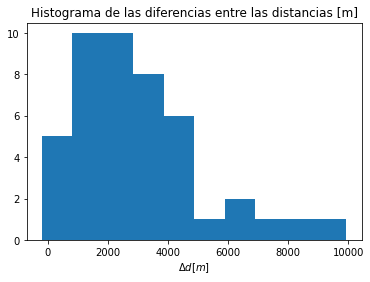

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Histograma de las diferencias entre las distancias [m]')
ax.hist(d['delta_d'])
ax.set_xlabel('$\Delta d [m]$')
plt.show()

Veamos por último cuál es la ruta para la cual la diferencia es mayor

In [ ]:
ruta_maxima = d.sort_values(by = 'delta_d', ascending = False).iloc[0]
ruta_maxima

p1         POINT (-58.38010152408503 -34.634113023173896)
p2          POINT (-58.48848589830587 -34.56120909671498)
du                                                22760.8
de                                           12816.331196
delta_d                                       9944.468804
Name: 5, dtype: object

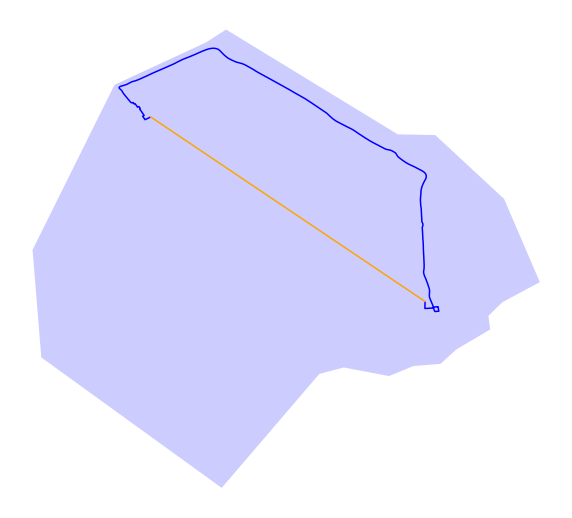

In [ ]:
lon1, lat1 = np.array(ruta_maxima['p1'].coords).T
lon2, lat2 = np.array(ruta_maxima['p2'].coords).T

profile = 'car' # En auto

url = f'http://router.project-osrm.org/route/v1/{profile}/{lon1[0]},{lat1[0]};{lon2[0]},{lat2[0]}?overview=full&geometries=geojson'

s = requests.sessions.Session() # Generamos una sesión, veremos esto en detalle la clase que viene
r = s.get(url)

ruta = geometry.LineString(r.json()['routes'][0]['geometry']['coordinates'])
d_auxiliar = gpd.GeoDataFrame([pol_ciudad,ruta, geometry.LineString([[lon1,lat1], [lon2,lat2]])], geometry = 0)

fig, ax = plt.subplots(figsize = (10,10))
d_auxiliar[:1].plot(color = 'blue', alpha = 0.2, ax = ax)
d_auxiliar[1:3].plot(color = ['blue','orange','red'], ax = ax)
ax.axis('off')
plt.show()

De [acá](https://geojson.io) extraje el polígono